In [ ]:
import os
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Layer, Dense, Dropout, Input, Bidirectional, Attention, Permute, Multiply
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from joblib import Parallel, delayed
import multiprocessing
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True) if tf.config.list_physical_devices('GPU') else None

In [ ]:
### BASELINE MODELS ###

In [ ]:
def read_price_csv(path):
    df = pd.read_csv(path)
    date_col = next((c for c in df.columns if str(c).lower() in ("date", "timestamp")), df.columns[0])
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col).set_index(date_col)
    candidates = [c for c in df.columns if str(c).lower().replace(" ", "") in ("adjclose", "adjustedclose", "adjclose*", "close")]
    price_col = next((c for c in candidates if "adj" in str(c).lower()), candidates[0] if candidates else df.select_dtypes(include=[np.number]).columns[-1])
    return df[price_col].astype(float).dropna().rename(os.path.splitext(os.path.basename(path))[0])

def to_monthly_total_return_prices(daily_price):
    return daily_price.resample(MONTHLY_RESAMPLE_RULE).last()

def make_monthly_returns(price_df):
    return price_df.pct_change().dropna(how="all")

def momentum_signal(monthly_prices, lookback=12, skip_recent=False):
    px = monthly_prices
    mom = (px.shift(2 if skip_recent else 1) / px.shift(lookback + (1 if skip_recent else 0))) - 1.0
    return np.sign(mom).replace(0, np.nan).fillna(0)

def rolling_inverse_vol_weights(monthly_rets, vol_lookback=12):
    vol = monthly_rets.rolling(vol_lookback).std()
    return 1.0 / vol.replace(0, np.nan)

def target_vol_scale(weights, cov, target_ann_vol=0.10):
    if cov.isnull().values.any() or (weights.abs().sum() < 1e-12):
        return 0.0
    w = weights.values.reshape(-1, 1)
    try:
        port_var_m = (w.T @ cov.values @ w)[0, 0]  # Extract scalar
        if port_var_m <= 0:
            return 0.0
        return target_ann_vol / math.sqrt(12.0 * port_var_m)
    except (ValueError, np.linalg.LinAlgError):
        return 0.0

def compute_turnover(curr_w, prev_w):
    return float((curr_w - prev_w).abs().sum()) if prev_w is not None else 0.0

def perf_stats(oos_rets, freq=12):
    ann_ret = (1 + oos_rets).prod()**(freq/len(oos_rets)) - 1 if len(oos_rets) > 0 else np.nan
    ann_vol = oos_rets.std() * math.sqrt(freq)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
    cum = (1 + oos_rets).cumprod()
    dd = cum / cum.cummax() - 1.0
    max_dd = dd.min()
    calmar = ann_ret / abs(max_dd) if max_dd < 0 else np.nan
    return {
        "Ann.Return": ann_ret,
        "Ann.Vol": ann_vol,
        "Sharpe": sharpe,
        "MaxDD": max_dd,
        "Calmar": calmar
    }

def build_clf(n_features):
    m = tf.keras.Sequential([
        Input(shape=(MOM_LOOKBACK_MONTHS, n_features)),
        LSTM(64, return_sequences=True),
        Dropout(0.1),
        LSTM(32),
        Dense(1, activation="sigmoid")
    ])
    m.compile(optimizer=Adam(learning_rate=LR), loss="binary_crossentropy")
    return m

In [ ]:
DATA_DIR = "./"
TICKERS = ["^spx", "eem", "iwm", "ief", "tlt", "shy", "tip", "lqd", "hyg", "uup", "fxe", "gld", "slv", "uso", "vnq"]
TICKERS_TO_FILES = {t: f"{t}_us_m.csv" for t in TICKERS}
MONTHLY_RESAMPLE_RULE = "ME"
MOM_LOOKBACK_MONTHS = 12
SKIP_RECENT_MONTH = False
VOL_LOOKBACK_MONTHS = 12
COV_LOOKBACK_MONTHS = 36
TARGET_ANNUAL_VOL = 0.10
COST_BPS_PER_SIDE = 5
MIN_HISTORY_FOR_SIGNAL = max(MOM_LOOKBACK_MONTHS, VOL_LOOKBACK_MONTHS, COV_LOOKBACK_MONTHS) + 1
COMMON_START = "2007-04-30"
OOS_START = "2010-06-30"
EPOCHS = 30
BATCH_SIZE = 32
LR = 0.001

monthly_prices = {}
for t in TICKERS:
    path = os.path.join(DATA_DIR, TICKERS_TO_FILES.get(t, f"{t}.csv"))
    if not os.path.exists(path):
        raise FileNotFoundError(f"CSV for {t} not found at {path}")
    s = read_price_csv(path)
    monthly_prices[t.upper()] = to_monthly_total_return_prices(s)

px_m = pd.concat(monthly_prices.values(), axis=1)
px_m.columns = list(monthly_prices.keys())
px_m = px_m.sort_index().dropna(how="all")
px_m = px_m[px_m.index >= COMMON_START].dropna(how="any")

re_m = make_monthly_returns(px_m)
re_m.to_csv("asset_monthly_returns.csv")

# TSMOM Baseline
sig = momentum_signal(px_m, MOM_LOOKBACK_MONTHS, SKIP_RECENT_MONTH)
inv_vol = rolling_inverse_vol_weights(re_m, VOL_LOOKBACK_MONTHS)
raw_w = sig * inv_vol
gross = raw_w.abs().sum(axis=1)
w_norm = raw_w.div(gross, axis=0).fillna(0.0)

cov_dict = {re_m.index[i]: re_m.iloc[i-COV_LOOKBACK_MONTHS:i].cov() for i in range(COV_LOOKBACK_MONTHS, len(re_m))}

port_ret, port_ret_net, turnover_list, w_final_records, w_prev = [], [], [], [], None
for dt in re_m.index:
    w = w_norm.loc[dt] if dt in w_norm.index else None
    r = re_m.loc[dt] if dt in re_m.index else None
    if w is None or r is None or w.abs().sum() == 0 or r.isnull().all():
        port_ret.append(np.nan)
        port_ret_net.append(np.nan)
        turnover_list.append(np.nan)
        w_final_records.append(pd.Series(index=w_norm.columns, dtype=float))
        w_prev = w
        continue
    cov = cov_dict.get(dt, None)
    k = 1.0 if cov is None or cov.isnull().values.any() else target_vol_scale(w, cov, TARGET_ANNUAL_VOL)
    w_t = (w * k).fillna(0.0)
    pr = float((w_t * r).sum())
    to = compute_turnover(w_t, w_prev)
    cost = to * (COST_BPS_PER_SIDE / 10000.0)
    port_ret.append(pr)
    port_ret_net.append(pr - cost)
    turnover_list.append(to)
    w_final_records.append(w_t)
    w_prev = w_t

port = pd.DataFrame({
    "ret_gross": pd.Series(port_ret, index=re_m.index),
    "ret_net": pd.Series(port_ret_net, index=re_m.index),
    "turnover": pd.Series(turnover_list, index=re_m.index)
}).dropna()
weights_final = pd.DataFrame(w_final_records, index=re_m.index).loc[port.index]
valid_start_idx = re_m.index[min(len(re_m.index)-1, MIN_HISTORY_FOR_SIGNAL)] if len(re_m.index) > MIN_HISTORY_FOR_SIGNAL else re_m.index[0]
port = port[port.index >= valid_start_idx]
weights_final = weights_final.loc[port.index]

stats_gross = perf_stats(port["ret_gross"].dropna())
stats_net = perf_stats(port["ret_net"].dropna())
summary = pd.DataFrame([stats_gross, stats_net], index=["Gross", "Net"]).T
summary.loc["Avg Turnover (mo)", :] = port["turnover"].mean()
print("Common start date:", COMMON_START)
print("Out-of-sample start:", valid_start_idx.date())
print("\n=== TSMOM Baseline Summary ===")
print(summary.map(lambda x: f"{x:.4f}" if isinstance(x, (float, np.floating)) else x))

summary.to_csv("tsmom_baseline_summary.csv")
port.to_csv("tsmom_baseline_returns.csv")
weights_final.to_csv("tsmom_baseline_weights.csv")
print("\nSaved: tsmom_baseline_summary.csv, tsmom_baseline_returns.csv, tsmom_baseline_weights.csv")

# LSTM Model
data = re_m.values
X_shared, y_all = [], []
for i in range(MOM_LOOKBACK_MONTHS, len(data)):
    X_shared.append(data[i-MOM_LOOKBACK_MONTHS:i])
    y_all.append(data[i])
X_shared, y_all = np.array(X_shared), np.array(y_all)
seq_dates = re_m.index[MOM_LOOKBACK_MONTHS:]

split_date = pd.to_datetime(OOS_START)
split_idx = seq_dates.get_loc(split_date)
train_idx, test_idx = np.arange(split_idx), np.arange(split_idx, len(seq_dates))

pred_prob = pd.DataFrame(index=seq_dates[test_idx], columns=re_m.columns, dtype=float)
metrics = {}
feat_scaler = StandardScaler()
X_tr_s = feat_scaler.fit_transform(X_shared[train_idx].reshape(-1, X_shared.shape[-1])).reshape(X_shared[train_idx].shape)
X_te_s = feat_scaler.transform(X_shared[test_idx].reshape(-1, X_shared.shape[-1])).reshape(X_shared[test_idx].shape)

for asset in re_m.columns:
    asset_idx = re_m.columns.get_loc(asset)
    y = (y_all[:, asset_idx] > 0).astype(int)
    y_tr, y_te = y[train_idx], y[test_idx]
    model = build_clf(n_features=re_m.shape[1])  # New model per asset
    es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    model.fit(X_tr_s, y_tr, validation_data=(X_te_s, y_te), epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=False, verbose=0, callbacks=[es])
    prob = model.predict(X_te_s, verbose=0).ravel()
    pred_prob[asset] = prob
    preds_bin = (prob >= 0.5).astype(int)
    metrics[asset] = {
        "Acc": float(accuracy_score(y_te, preds_bin)),
        "AUC": float(roc_auc_score(y_te, prob)) if len(np.unique(y_te)) > 1 else np.nan
    }

conf = 2 * pred_prob - 1.0
signals = np.sign(conf).shift(1).dropna()
weights = conf.shift(1).loc[signals.index]
rets_oos = re_m.loc[weights.index]
gross = weights.abs().sum(axis=1).replace(0, np.nan)
weights_norm = weights.div(gross, axis=0).fillna(0)

port_lstm_gross, port_lstm_net, turnover_list, w_prev = [], [], [], None
for dt in weights_norm.index:
    w = weights_norm.loc[dt]
    r = rets_oos.loc[dt]
    if w.abs().sum() == 0 or r.isnull().all():
        port_lstm_gross.append(np.nan)
        port_lstm_net.append(np.nan)
        turnover_list.append(np.nan)
        w_prev = w
        continue
    pr = float((w * r).sum())
    to = compute_turnover(w, w_prev)
    cost = to * (COST_BPS_PER_SIDE / 10000.0)
    port_lstm_gross.append(pr)
    port_lstm_net.append(pr - cost)
    turnover_list.append(to)
    w_prev = w

port_lstm_df = pd.DataFrame({
    "ret_gross": pd.Series(port_lstm_gross, index=weights_norm.index),
    "ret_net": pd.Series(port_lstm_net, index=weights_norm.index),
    "turnover": pd.Series(turnover_list, index=weights_norm.index)
}).dropna()

# Calculate performance stats
stats_lstm_gross = perf_stats(port_lstm_df["ret_gross"])
stats_lstm_net = perf_stats(port_lstm_df["ret_net"])
stats_lstm = pd.DataFrame([stats_lstm_gross, stats_lstm_net], index=["Gross", "Net"]).T
stats_lstm["Start"] = port_lstm_df.index[0].date()
stats_lstm["End"] = port_lstm_df.index[-1].date()
stats_lstm["Avg Turnover (mo)"] = port_lstm_df["turnover"].mean()
stats_lstm["Months"] = len(port_lstm_df)
print("\n=== LSTM-TSMOM (OOS) ===")
print(stats_lstm.map(lambda x: f"{x:.4f}" if isinstance(x, (float, np.floating)) else x))

# Save outputs
port_lstm_df.to_csv("lstm_portfolio_oos.csv")
pred_prob.to_csv("lstm_preds_oos.csv")
signals.to_csv("lstm_signals_oos.csv")
print("\nSaved: lstm_portfolio_oos.csv, lstm_preds_oos.csv, lstm_signals_oos.csv")

Common start date: 2007-04-30
Out-of-sample start: 2010-06-30

=== TSMOM Baseline Summary ===
                     Gross      Net
Ann.Return          0.0730   0.0641
Ann.Vol             0.1010   0.1012
Sharpe              0.7226   0.6334
MaxDD              -0.2143  -0.2411
Calmar              0.3405   0.2659
Avg Turnover (mo)   1.3863   1.3863

Saved: tsmom_baseline_summary.csv, tsmom_baseline_returns.csv, tsmom_baseline_weights.csv

=== LSTM-TSMOM (OOS) ===
              Gross      Net       Start         End Avg Turnover (mo)  Months
Ann.Return   0.0762   0.0752  2010-07-31  2025-08-31            0.1594     182
Ann.Vol      0.0893   0.0893  2010-07-31  2025-08-31            0.1594     182
Sharpe       0.8533   0.8418  2010-07-31  2025-08-31            0.1594     182
MaxDD       -0.2007  -0.2010  2010-07-31  2025-08-31            0.1594     182
Calmar       0.3797   0.3740  2010-07-31  2025-08-31            0.1594     182

Saved: lstm_portfolio_oos.csv, lstm_preds_oos.csv, lstm_signal

/tmp/ipython-input-3433071044.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tsmom_cum = tsmom_cum.reindex(common_index).fillna(method='ffill')
/tmp/ipython-input-3433071044.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lstm_cum = lstm_cum.reindex(common_index).fillna(method='ffill')


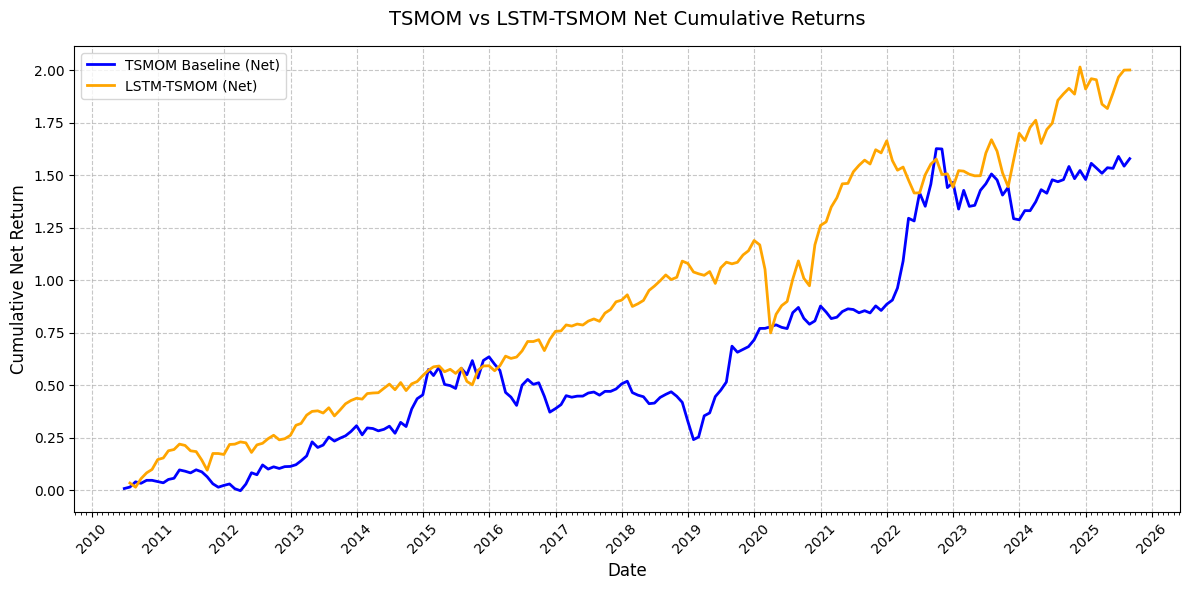

In [ ]:
def plot_cumulative_returns(tsmom_returns, lstm_returns, title="TSMOM vs LSTM-TSMOM Net Cumulative Returns", figsize=(12, 6)):

    tsmom_cum = (1 + tsmom_returns).cumprod() - 1
    lstm_cum = (1 + lstm_returns).cumprod() - 1

    common_index = tsmom_returns.index.union(lstm_returns.index)
    tsmom_cum = tsmom_cum.reindex(common_index).fillna(method='ffill')
    lstm_cum = lstm_cum.reindex(common_index).fillna(method='ffill')

    plt.figure(figsize=figsize)
    plt.plot(tsmom_cum.index, tsmom_cum, label='TSMOM Baseline (Net)', color='blue', linewidth=2)
    plt.plot(lstm_cum.index, lstm_cum, label='LSTM-TSMOM (Net)', color='orange', linewidth=2)

    plt.title(title, fontsize=14, pad=15)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cumulative Net Return', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)

    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)

    plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
    plt.tight_layout()
    plt.show()

port = pd.read_csv("tsmom_baseline_returns.csv", index_col=0, parse_dates=True)
port_lstm_df = pd.read_csv("lstm_portfolio_oos.csv", index_col=0, parse_dates=True)
plot_cumulative_returns(port["ret_net"], port_lstm_df["ret_net"])

In [ ]:
### PERFORMANCE BY MODEL ARCHITECTURE ###

In [ ]:
def perf_stats(r, freq=12):
    if r.empty:
        return {k: np.nan for k in ["Ann.Return", "Ann.Vol", "Sharpe", "MaxDD", "Calmar"]}
    ann_ret = (1 + r).prod()**(freq / len(r)) - 1 if len(r) > 0 else np.nan
    ann_vol = r.std() * math.sqrt(freq)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
    cum = (1 + r).cumprod()
    peak = cum.cummax()
    dd = cum / peak - 1.0
    maxdd = dd.min()
    calmar = ann_ret / abs(maxdd) if maxdd < 0 else np.nan
    return {
        "Ann.Return": ann_ret,
        "Ann.Vol": ann_vol,
        "Sharpe": sharpe,
        "MaxDD": maxdd,
        "Calmar": calmar
    }

def compute_turnover(curr_w, prev_w):
    if prev_w is None:
        return 0.0
    return float((curr_w - prev_w).abs().sum())

def backtest_with_costs(weights, rets_oos):
    dates = weights.index
    port_ret_gross = []
    port_ret_net = []
    turnover_list = []
    w_prev = None

    for dt in dates:
        w_t = weights.loc[dt]
        r_t = rets_oos.loc[dt]
        port_gross = float((w_t * r_t).sum())
        turnover = compute_turnover(w_t, w_prev)
        cost = turnover * (COST_BPS_PER_SIDE / 10000.0)
        port_net = port_gross - cost
        port_ret_gross.append(port_gross)
        port_ret_net.append(port_net)
        turnover_list.append(turnover)
        w_prev = w_t

    gross_returns = pd.Series(port_ret_gross, index=dates)
    net_returns = pd.Series(port_ret_net, index=dates)
    turnover_series = pd.Series(turnover_list, index=dates)
    stats_gross = perf_stats(gross_returns)
    stats_net = perf_stats(net_returns)
    avg_turnover = turnover_series.mean()
    stats_gross["Avg Turnover"] = avg_turnover
    stats_net["Avg Turnover"] = avg_turnover
    cost_drag = stats_gross["Ann.Return"] - stats_net["Ann.Return"]

    return {
        'gross_returns': gross_returns,
        'net_returns': net_returns,
        'turnover': turnover_series,
        'stats_gross': stats_gross,
        'stats_net': stats_net,
        'cost_drag': cost_drag
    }

def build_baseline_clf(n_features):
    m = tf.keras.Sequential([
        Input(shape=(LOOKBACK, n_features)),
        LSTM(64, return_sequences=True),
        Dropout(0.1),
        LSTM(32),
        Dense(1, activation="sigmoid")
    ])
    m.compile(optimizer=Adam(learning_rate=LR), loss="binary_crossentropy")
    return m

def build_multi_task_clf(n_features, n_assets):
    m = tf.keras.Sequential([
        Input(shape=(LOOKBACK, n_features)),
        LSTM(64, return_sequences=True),
        Dropout(0.1),
        LSTM(32),
        Dense(n_assets, activation="sigmoid")
    ])
    m.compile(optimizer=Adam(learning_rate=LR), loss="binary_crossentropy")
    return m

def build_bidir_clf(n_features):
    m = tf.keras.Sequential([
        Input(shape=(LOOKBACK, n_features)),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.1),
        Bidirectional(LSTM(32)),
        Dense(1, activation="sigmoid")
    ])
    m.compile(optimizer=Adam(learning_rate=LR), loss="binary_crossentropy")
    return m

def build_attention_clf(n_features):
    inputs = Input(shape=(LOOKBACK, n_features))
    lstm_out = LSTM(64, return_sequences=True)(inputs)
    lstm_out = Dropout(0.1)(lstm_out)
    attention = Dense(1, activation="tanh")(lstm_out)
    attention = Permute((2, 1))(attention)
    attention = Dense(LOOKBACK, activation="softmax")(attention)
    attention = Permute((2, 1))(attention)
    sent_representation = Multiply()([lstm_out, attention])
    lstm_out = LSTM(32)(sent_representation)
    outputs = Dense(1, activation="sigmoid")(lstm_out)
    m = tf.keras.Model(inputs=inputs, outputs=outputs)
    m.compile(optimizer=Adam(learning_rate=LR), loss="binary_crossentropy")
    return m

In [ ]:
LOOKBACK = 12
OOS_START = "2010-06-30"
EPOCHS = 30
BATCH_SIZE = 32
LR = 0.001
COST_BPS_PER_SIDE = 5

if not os.path.exists("asset_monthly_returns.csv"):
    raise FileNotFoundError("asset_monthly_returns.csv not found.")
rets = pd.read_csv("asset_monthly_returns.csv", index_col=0, parse_dates=True)
rets = rets.dropna(how="all")
assets = rets.columns

data = rets.values
X = []
y = []
for i in range(LOOKBACK, len(data)):
    X.append(data[i-LOOKBACK:i])
    y.append(data[i])
X = np.array(X)
y = np.array(y)
dates = rets.index[LOOKBACK:]

split_date = pd.to_datetime(OOS_START)
split_idx = dates.get_loc(split_date)
train_idx = np.arange(split_idx)
test_idx = np.arange(split_idx, len(dates))

X_tr_raw, y_tr = X[train_idx], y[train_idx]
X_te_raw, y_te = X[test_idx], y[test_idx]
rets_oos = rets.loc[dates[test_idx]]
y_te_dir = (y_te > 0).astype(int)

feat_scaler = StandardScaler()
X_tr_s = feat_scaler.fit_transform(X_tr_raw.reshape(-1, X_tr_raw.shape[-1])).reshape(X_tr_raw.shape)
X_te_s = feat_scaler.transform(X_te_raw.reshape(-1, X_te_raw.shape[-1])).reshape(X_te_raw.shape)

all_results = {}

tsmom_signal = np.sign(rets.rolling(window=12).mean().shift(1))
tsmom_weights = tsmom_signal.loc[rets_oos.index]
tsmom_weights = tsmom_weights.div(tsmom_weights.abs().sum(axis=1), axis=0).fillna(0)
all_results["TSMOM"] = backtest_with_costs(tsmom_weights, rets_oos)

pred_prob_baseline = pd.DataFrame(index=dates[test_idx], columns=assets, dtype=float)
for asset in assets:
    y_tr_asset = (y_tr[:, assets.get_loc(asset)] > 0).astype(int)
    y_te_asset = y_te_dir[:, assets.get_loc(asset)]
    model = build_baseline_clf(n_features=X.shape[2])
    es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    model.fit(X_tr_s, y_tr_asset, validation_data=(X_te_s, y_te_asset), epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=False, verbose=0, callbacks=[es])
    pred_prob_baseline[asset] = model.predict(X_te_s, verbose=0).ravel()

conf_baseline = 2 * pred_prob_baseline - 1.0
weights_baseline = conf_baseline.shift(1).loc[rets_oos.index]
weights_baseline = weights_baseline.div(weights_baseline.abs().sum(axis=1), axis=0).fillna(0)
all_results["Baseline"] = backtest_with_costs(weights_baseline, rets_oos)

y_tr_multi = (y_tr > 0).astype(int)
y_te_multi = y_te_dir
model = build_multi_task_clf(n_features=X.shape[2], n_assets=len(assets))
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
model.fit(X_tr_s, y_tr_multi, validation_data=(X_te_s, y_te_multi), epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=False, verbose=0, callbacks=[es])
pred_prob_multi = pd.DataFrame(model.predict(X_te_s, verbose=0), index=dates[test_idx], columns=assets)
conf_multi = 2 * pred_prob_multi - 1.0
weights_multi = conf_multi.shift(1).loc[rets_oos.index]
weights_multi = weights_multi.div(weights_multi.abs().sum(axis=1), axis=0).fillna(0)
all_results["Multi-Task"] = backtest_with_costs(weights_multi, rets_oos)

pred_prob_bidir = pd.DataFrame(index=dates[test_idx], columns=assets, dtype=float)
for asset in assets:
    y_tr_asset = (y_tr[:, assets.get_loc(asset)] > 0).astype(int)
    y_te_asset = y_te_dir[:, assets.get_loc(asset)]
    model = build_bidir_clf(n_features=X.shape[2])
    es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    model.fit(X_tr_s, y_tr_asset, validation_data=(X_te_s, y_te_asset), epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=False, verbose=0, callbacks=[es])
    pred_prob_bidir[asset] = model.predict(X_te_s, verbose=0).ravel()

conf_bidir = 2 * pred_prob_bidir - 1.0
weights_bidir = conf_bidir.shift(1).loc[rets_oos.index]
weights_bidir = weights_bidir.div(weights_bidir.abs().sum(axis=1), axis=0).fillna(0)
all_results["Bidirectional"] = backtest_with_costs(weights_bidir, rets_oos)

pred_prob_attention = pd.DataFrame(index=dates[test_idx], columns=assets, dtype=float)
for asset in assets:
    y_tr_asset = (y_tr[:, assets.get_loc(asset)] > 0).astype(int)
    y_te_asset = y_te_dir[:, assets.get_loc(asset)]
    model = build_attention_clf(n_features=X.shape[2])
    es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    model.fit(X_tr_s, y_tr_asset, validation_data=(X_te_s, y_te_asset), epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=False, verbose=0, callbacks=[es])
    pred_prob_attention[asset] = model.predict(X_te_s, verbose=0).ravel()

conf_attention = 2 * pred_prob_attention - 1.0
weights_attention = conf_attention.shift(1).loc[rets_oos.index]
weights_attention = weights_attention.div(weights_attention.abs().sum(axis=1), axis=0).fillna(0)
all_results["Attention"] = backtest_with_costs(weights_attention, rets_oos)

gross_stats = {}
net_stats = {}
cost_impact = {}

for strategy, results in all_results.items():
    gross_stats[strategy] = results['stats_gross']
    net_stats[strategy] = results['stats_net']
    cost_impact[strategy] = {
        'Cost Drag (Ann.)': results['cost_drag'],
        'Avg Turnover': results['stats_gross']['Avg Turnover']
    }

gross_df = pd.DataFrame(gross_stats).T
net_df = pd.DataFrame(net_stats).T
cost_df = pd.DataFrame(cost_impact).T

print("\n" + "="*80)
print("LSTM ARCHITECTURE PERFORMANCE COMPARISON")
print("="*80)
print("\n--- GROSS PERFORMANCE (Before Costs) ---")
print(gross_df.round(4).to_string())
print("\n--- NET PERFORMANCE (After Costs) ---")
print(net_df.round(4).to_string())
print("\n--- TRANSACTION COST IMPACT ---")
print(cost_df.round(4).to_string())

net_sharpe_ranking = net_df['Sharpe'].sort_values(ascending=False)
print(f"\n--- NET SHARPE RATIO RANKING ---")
for i, (strategy, sharpe) in enumerate(net_sharpe_ranking.items(), 1):
    print(f"{i}. {strategy:<15} {sharpe:.4f}")

gross_df.to_csv("lstm_architectures_gross_performance.csv")
net_df.to_csv("lstm_architectures_net_performance.csv")
cost_df.to_csv("lstm_architectures_cost_impact.csv")

for strategy, results in all_results.items():
    strategy_df = pd.DataFrame({
        'gross_returns': results['gross_returns'],
        'net_returns': results['net_returns'],
        'turnover': results['turnover']
    })
    strategy_df.to_csv(f"lstm_{strategy.lower()}_detailed_results.csv")


LSTM ARCHITECTURE PERFORMANCE COMPARISON

--- GROSS PERFORMANCE (Before Costs) ---
               Ann.Return  Ann.Vol  Sharpe   MaxDD  Calmar  Avg Turnover
TSMOM              0.0208   0.0613  0.3388 -0.1651  0.1257        0.2317
Baseline           0.0663   0.0809  0.8194 -0.1658  0.4000        0.1784
Multi-Task         0.0417   0.0583  0.7149 -0.1076  0.3876        0.2644
Bidirectional      0.0666   0.0927  0.7181 -0.2325  0.2864        0.2997
Attention          0.0835   0.1023  0.8159 -0.1882  0.4437        0.0524

--- NET PERFORMANCE (After Costs) ---
               Ann.Return  Ann.Vol  Sharpe   MaxDD  Calmar  Avg Turnover
TSMOM              0.0193   0.0613  0.3156 -0.1697  0.1140        0.2317
Baseline           0.0652   0.0809  0.8054 -0.1664  0.3918        0.1784
Multi-Task         0.0400   0.0583  0.6866 -0.1131  0.3542        0.2644
Bidirectional      0.0647   0.0927  0.6975 -0.2337  0.2768        0.2997
Attention          0.0832   0.1023  0.8127 -0.1884  0.4415        0.0524



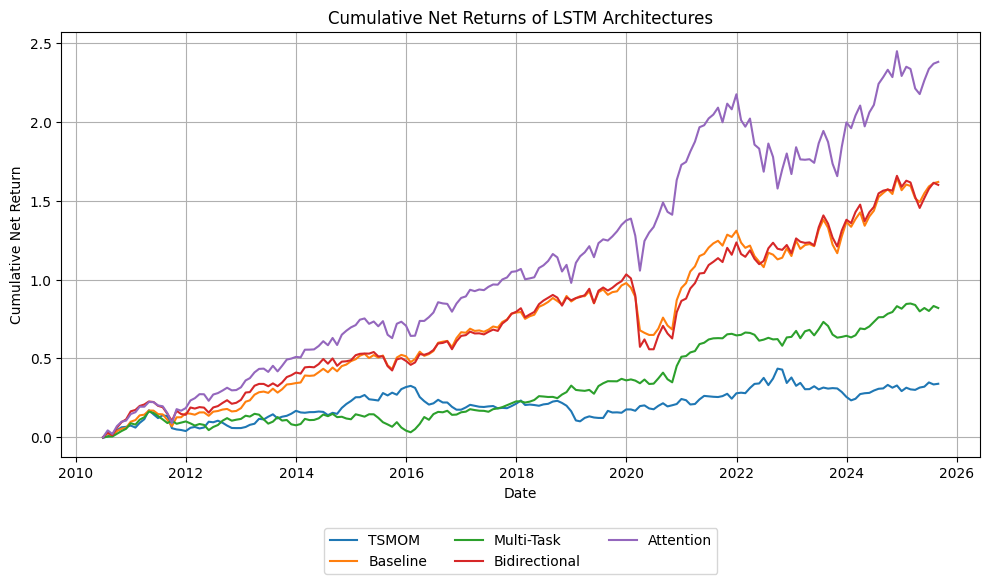

In [ ]:
strategies = ["TSMOM", "Baseline", "Multi-Task", "Bidirectional", "Attention"]
plt.figure(figsize=(10, 6))

for strategy in strategies:
    file_name = f"lstm_{strategy.lower()}_detailed_results.csv"
    try:
        df = pd.read_csv(file_name, index_col=0, parse_dates=True)
        cumulative_returns = (1 + df["net_returns"]).cumprod() - 1
        plt.plot(cumulative_returns.index, cumulative_returns, label=strategy)
    except FileNotFoundError:
        print(f"Warning: {file_name} not found. Skipping {strategy}.")

plt.title("Cumulative Net Returns of LSTM Architectures")
plt.xlabel("Date")
plt.ylabel("Cumulative Net Return")
plt.grid(True)
plt.legend(bbox_to_anchor=(0.5, -0.15), loc="upper center", ncol=3)
plt.tight_layout()
plt.show()
plt.savefig("lstm_net_returns_comparison.png")
plt.close()

In [ ]:
### Attention Multi-task Walk forward

In [ ]:
class SimpleAttention(Layer):
    def __init__(self, **kwargs):
        super(SimpleAttention, self).__init__(**kwargs)
    def build(self, input_shape):
        self.attention_weights = self.add_weight(
            name='attention_weights',
            shape=(input_shape[-1], 1),
            initializer='glorot_uniform',
            trainable=True
        )
        super(SimpleAttention, self).build(input_shape)
    def call(self, inputs):
        attention_scores = tf.nn.tanh(tf.tensordot(inputs, self.attention_weights, axes=1))
        attention_weights = tf.nn.softmax(attention_scores, axis=1)
        weighted_inputs = inputs * attention_weights
        output = tf.reduce_sum(weighted_inputs, axis=1)
        return output
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[2])

def perf_stats(r, freq=12):
    if r.empty:
        return {k: np.nan for k in ["Ann.Return", "Ann.Vol", "Sharpe", "MaxDD", "Calmar"]}
    ann_ret = (1 + r).prod()**(freq / len(r)) - 1 if len(r) > 0 else np.nan
    ann_vol = r.std() * math.sqrt(freq)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
    cum = (1 + r).cumprod()
    peak = cum.cummax()
    dd = cum / peak - 1.0
    maxdd = dd.min()
    calmar = ann_ret / abs(maxdd) if maxdd < 0 else np.nan
    return {
        "Ann.Return": ann_ret,
        "Ann.Vol": ann_vol,
        "Sharpe": sharpe,
        "MaxDD": maxdd,
        "Calmar": calmar
    }

def compute_turnover(curr_w, prev_w):
    if prev_w is None:
        return 0.0
    return float(np.abs(curr_w - prev_w).sum())

def build_attention_multi_task_clf(n_features, n_assets):
    inputs = Input(shape=(LOOKBACK, n_features))
    lstm_out = LSTM(64, return_sequences=True)(inputs)
    lstm_out = Dropout(0.1)(lstm_out)
    attention_output = SimpleAttention()(lstm_out)
    outputs = Dense(n_assets, activation="sigmoid")(attention_output)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=LR), loss="binary_crossentropy")
    return model

def build_baseline_multi_task_clf(n_features, n_assets):
    model = tf.keras.Sequential([
        Input(shape=(LOOKBACK, n_features)),
        LSTM(64, return_sequences=True),
        Dropout(0.1),
        LSTM(32),
        Dense(n_assets, activation="sigmoid")
    ])
    model.compile(optimizer=Adam(learning_rate=LR), loss="binary_crossentropy")
    return model

def backtest_with_costs(weights_df, returns_df):
    dates = weights_df.index
    port_ret_gross, port_ret_net, turnover_list = [], [], []
    w_prev = None
    for dt in dates:
        w_t = weights_df.loc[dt].values
        r_t = returns_df.loc[dt].values
        port_gross = float(np.dot(w_t, r_t))
        turnover = compute_turnover(w_t, w_prev)
        cost = turnover * (COST_BPS_PER_SIDE / 10000.0)
        port_net = port_gross - cost
        port_ret_gross.append(port_gross)
        port_ret_net.append(port_net)
        turnover_list.append(turnover)
        w_prev = w_t
    return (
        pd.Series(port_ret_gross, index=dates, name='gross'),
        pd.Series(port_ret_net, index=dates, name='net'),
        pd.Series(turnover_list, index=dates, name='turnover')
    )

def run_walkforward_strategy(model_builder, model_name):
    print(f"\n--- Running {model_name} ---")
    pred_prob_list, true_returns_list = [], []
    start_idx = dates.get_loc(pd.to_datetime(OOS_START))
    window_count = 0
    for i in range(start_idx, len(dates), PREDICT_PERIOD):
        train_end_idx = i
        train_start_idx = max(0, train_end_idx - TRAIN_PERIOD)
        test_end_idx = min(len(dates), i + PREDICT_PERIOD)
        if test_end_idx <= train_end_idx:
            continue
        X_train_raw = X[train_start_idx:train_end_idx]
        y_train = y_dir[train_start_idx:train_end_idx]
        X_test_raw = X[train_end_idx:test_end_idx]
        y_test = y_dir[train_end_idx:test_end_idx]
        if len(X_train_raw) < LOOKBACK or len(X_test_raw) == 0:
            continue
        window_count += 1
        if window_count % 10 == 1:
            train_date = dates[train_start_idx].strftime('%Y-%m')
            test_date = dates[train_end_idx].strftime('%Y-%m')
            print(f"  Window {window_count}: Training to {train_date}, predicting {test_date}")
        scaler = StandardScaler()
        X_train_s = scaler.fit_transform(X_train_raw.reshape(-1, X_train_raw.shape[-1])).reshape(X_train_raw.shape)
        X_test_s = scaler.transform(X_test_raw.reshape(-1, X_test_raw.shape[-1])).reshape(X_test_raw.shape)
        try:
            model = model_builder(n_features=X.shape[2], n_assets=len(assets))
            es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            model.fit(X_train_s, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                      validation_data=(X_test_s, y_test), callbacks=[es], verbose=0)
            prob = model.predict(X_test_s, verbose=0)
            prob_df = pd.DataFrame(prob, index=dates[train_end_idx:test_end_idx], columns=assets)
            pred_prob_list.append(prob_df)
            true_returns_list.append(rets.loc[dates[train_end_idx:test_end_idx]])
            del model
            tf.keras.backend.clear_session()
        except Exception as e:
            print(f"    Error in window {window_count}: {e}")
            continue
    if not pred_prob_list:
        print(f"No successful predictions for {model_name}!")
        return None, None, None
    oos_returns_df = pd.concat(true_returns_list, axis=0)
    oos_prob_df = pd.concat(pred_prob_list, axis=0)
    oos_weights_df = 2 * oos_prob_df - 1.0
    oos_weights_df = oos_weights_df.div(oos_weights_df.abs().sum(axis=1), axis=0).fillna(0)
    port_gross, port_net, turnover = backtest_with_costs(oos_weights_df, oos_returns_df)
    print(f"  Completed {window_count} windows")
    print(f"  OOS period: {oos_returns_df.index[0].date()} to {oos_returns_df.index[-1].date()}")
    return port_gross, port_net, turnover

In [ ]:
import warnings
warnings.filterwarnings('ignore')

LOOKBACK = 12
TRAIN_PERIOD = 36
PREDICT_PERIOD = 1
OOS_START = "2012-01-31"
EPOCHS = 30
BATCH_SIZE = 32
LR = 0.001
COST_BPS_PER_SIDE = 5

rets = pd.read_csv("asset_monthly_returns.csv", index_col=0, parse_dates=True)
rets = rets.dropna(how="all")
assets = rets.columns

data = rets.values
X, y = [], []
for i in range(LOOKBACK, len(data)):
    X.append(data[i-LOOKBACK:i])
    y.append(data[i])
X = np.array(X)
y = np.array(y)
dates = rets.index[LOOKBACK:]
y_dir = (y > 0).astype(int)
print(f"Data shapes: X={X.shape}, y={y.shape}, y_dir={y_dir.shape}")

print(f"\nStarting Walk-Forward Validation from {OOS_START}")
print(f"Training window: {TRAIN_PERIOD} months")
print(f"Transaction cost: {COST_BPS_PER_SIDE} bps per side")

results = {}

port_gross_att, port_net_att, turnover_att = run_walkforward_strategy(
    build_attention_multi_task_clf, "Attention Multi-Task LSTM"
)

if port_net_att is not None:
    stats_gross_att = perf_stats(port_gross_att)
    stats_net_att = perf_stats(port_net_att)
    stats_gross_att["Avg Turnover"] = turnover_att.mean()
    stats_net_att["Avg Turnover"] = turnover_att.mean()
    results["Attention"] = {
        'gross': stats_gross_att,
        'net': stats_net_att,
        'cost_drag': stats_gross_att["Ann.Return"] - stats_net_att["Ann.Return"]
    }

port_gross_base, port_net_base, turnover_base = run_walkforward_strategy(
    build_baseline_multi_task_clf, "Baseline Multi-Task LSTM"
)

if port_net_base is not None:
    stats_gross_base = perf_stats(port_gross_base)
    stats_net_base = perf_stats(port_net_base)
    stats_gross_base["Avg Turnover"] = turnover_base.mean()
    stats_net_base["Avg Turnover"] = turnover_base.mean()
    results["Baseline"] = {
        'gross': stats_gross_base,
        'net': stats_net_base,
        'cost_drag': stats_gross_base["Ann.Return"] - stats_net_base["Ann.Return"]
    }

print("\n" + "="*80)
print("ATTENTION vs BASELINE LSTM - WALK-FORWARD COMPARISON")
print("="*80)

if results:
    gross_comparison, net_comparison, cost_impact = {}, {}, {}
    for model_name, model_results in results.items():
        gross_comparison[model_name] = model_results['gross']
        net_comparison[model_name] = model_results['net']
        cost_impact[model_name] = {
            'Cost Drag (Ann.)': model_results['cost_drag'],
            'Avg Turnover': model_results['gross']['Avg Turnover']
        }
    gross_df = pd.DataFrame(gross_comparison).T
    net_df = pd.DataFrame(net_comparison).T
    cost_df = pd.DataFrame(cost_impact).T
    print("\n--- GROSS PERFORMANCE (Before Costs) ---")
    print(gross_df.round(4).to_string())
    print("\n--- NET PERFORMANCE (After Costs) ---")
    print(net_df.round(4).to_string())
    print("\n--- TRANSACTION COST IMPACT ---")
    print(cost_df.round(4).to_string())
    if len(results) > 1:
        best_model = net_df['Sharpe'].idxmax()
        print(f"\n--- WINNER (by Net Sharpe Ratio) ---")
        print(f"{best_model}: {net_df.loc[best_model, 'Sharpe']:.4f}")
    print(f"\n--- SAVING RESULTS ---")
    gross_df.to_csv("attention_vs_baseline_gross_performance.csv")
    net_df.to_csv("attention_vs_baseline_net_performance.csv")
    cost_df.to_csv("attention_vs_baseline_cost_impact.csv")
    if port_net_att is not None and port_net_base is not None:
        combined_results = pd.DataFrame({
            'Attention_Gross': port_gross_att,
            'Attention_Net': port_net_att,
            'Attention_Turnover': turnover_att,
            'Baseline_Gross': port_gross_base,
            'Baseline_Net': port_net_base,
            'Baseline_Turnover': turnover_base
        })
        combined_results.to_csv("attention_vs_baseline_detailed_results.csv")
        print("Saved detailed comparison files.")
else:
    print("No successful model runs to compare!")

print(f"\nWalk-forward validation complete!")

Data shapes: X=(208, 12, 15), y=(208, 15), y_dir=(208, 15)

Starting Walk-Forward Validation from 2012-01-31
Training window: 36 months
Transaction cost: 5 bps per side

--- Running Attention Multi-Task LSTM ---
  Window 1: Training to 2009-01, predicting 2012-01
  Window 11: Training to 2009-11, predicting 2012-11
  Window 21: Training to 2010-09, predicting 2013-09
  Window 31: Training to 2011-07, predicting 2014-07
  Window 41: Training to 2012-05, predicting 2015-05
  Window 51: Training to 2013-03, predicting 2016-03
  Window 61: Training to 2014-01, predicting 2017-01
  Window 71: Training to 2014-11, predicting 2017-11
  Window 81: Training to 2015-09, predicting 2018-09
  Window 91: Training to 2016-07, predicting 2019-07
  Window 101: Training to 2017-05, predicting 2020-05
  Window 111: Training to 2018-03, predicting 2021-03
  Window 121: Training to 2019-01, predicting 2022-01
  Window 131: Training to 2019-11, predicting 2022-11
  Window 141: Training to 2020-09, predicti

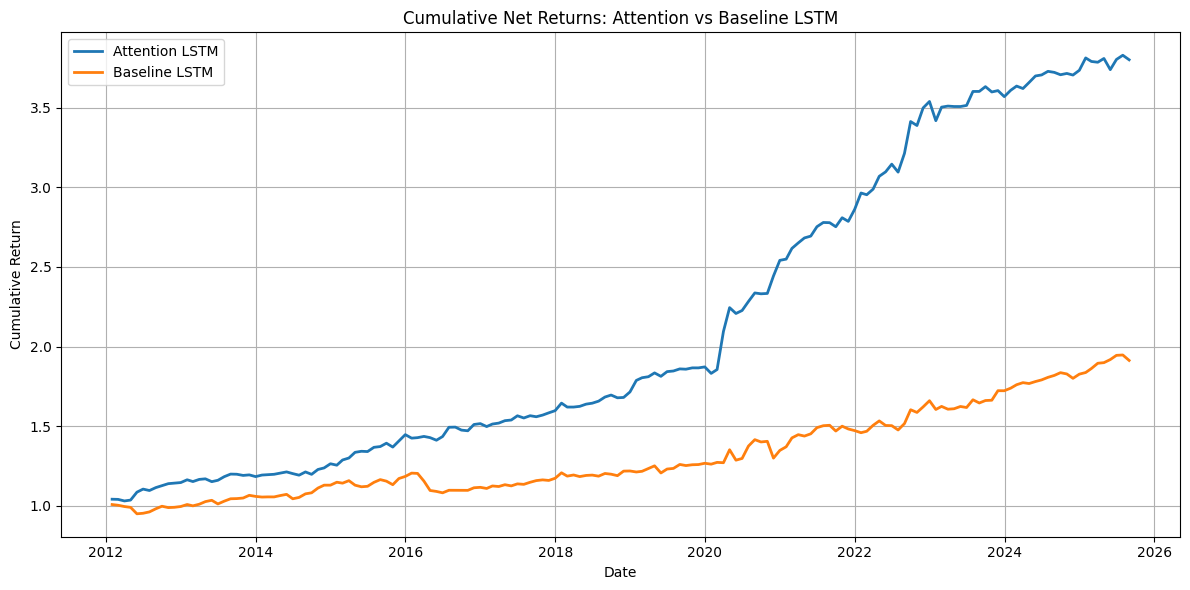

In [ ]:
import matplotlib.pyplot as plt

# Check both net return series are available
if port_net_att is not None and port_net_base is not None:
    # Compute cumulative returns
    cum_att = (1 + port_net_att).cumprod()
    cum_base = (1 + port_net_base).cumprod()

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(cum_att, label="Attention LSTM", linewidth=2)
    plt.plot(cum_base, label="Baseline LSTM", linewidth=2)
    plt.title("Cumulative Net Returns: Attention vs Baseline LSTM")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Net return series not available for one or both models.")